In [1]:
#Importing needed modules.
from os import mkdir , listdir
from shutil import copyfile , rmtree
from random import sample
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers , Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.applications import InceptionV3
import matplotlib.pyplot as plt
#Instancing from 'ImageDataGenerator' object.
generator = ImageDataGenerator(rescale=1/255,
                               rotation_range=40,
                               width_shift_range=0.2,
                               height_shift_range=0.2,
                               shear_range=0.2,
                               horizontal_flip=True,
                               zoom_range=0.2)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
#Making train , valid and test directories.
def Make_paths(base_path,labels)->str :
    '''function docstring'''
    if 'ready_to_gen' in listdir(base_path) :
        rmtree(f'{base_path}/ready_to_gen')
    mkdir(f'{base_path}/ready_to_gen')
    mkdir(f'{base_path}/ready_to_gen/train')
    mkdir(f'{base_path}/ready_to_gen/valid')
    mkdir(f'{base_path}/ready_to_gen/test')
    for Class in labels :
        if Class == 'ready_to_gen' or Class == 'Caries_Gingivitus_ToothDiscoloration_Ulcer-yolo_annotated-Dataset' :
            continue
            
        mkdir(f'{base_path}/ready_to_gen/train/{Class}')
        mkdir(f'{base_path}/ready_to_gen/valid/{Class}')
        mkdir(f'{base_path}/ready_to_gen/test/{Class}')
    return f'{base_path}/ready_to_gen/train' , f'{base_path}/ready_to_gen/valid' , f'{base_path}/ready_to_gen/test'
path = '/kaggle/working'
train , valid , test =  Make_paths(path,listdir("/kaggle/input/oral-diseases"))

In [3]:
def split_data(photo_path,label_name,train_size)->None :
    '''function docstring'''
    size_tr = (train_size*len(listdir(photo_path)))//100
    train_select = sample(listdir(photo_path),size_tr)
    reamin_photos = [photo for photo in listdir(photo_path) if photo not in train_select]
    size_valid = len(reamin_photos)//2
    valid_select = sample(reamin_photos,size_valid)
    for pic in listdir(photo_path) :
        if pic in train_select :
            copyfile(f'{photo_path}/{pic}',f'{train}/{label_name}/{pic}')
        elif pic in valid_select :
            copyfile(f'{photo_path}/{pic}',f'{valid}/{label_name}/{pic}')
        else :
            copyfile(f'{photo_path}/{pic}',f'{test}/{label_name}/{pic}')

lbl = [l for l in listdir("/kaggle/input/oral-diseases") if l != 'ready_to_gen' and l != 'Caries_Gingivitus_ToothDiscoloration_Ulcer-yolo_annotated-Dataset']
Addresses = ["/kaggle/input/oral-diseases/Data caries/Data caries/caries augmented data set/preview",
            "/kaggle/input/oral-diseases/Mouth Ulcer/Mouth Ulcer/Mouth_Ulcer_augmented_DataSet/preview",
            "/kaggle/input/oral-diseases/Tooth Discoloration/Tooth Discoloration /Tooth_discoloration_augmented_dataser/preview",
            "/kaggle/input/oral-diseases/hypodontia/hypodontia",
            "/kaggle/input/oral-diseases/Gingivitis/Gingivitis",
            "/kaggle/input/oral-diseases/Calculus/Calculus"]
for i in range(len(Addresses)) :
    split_data(Addresses[i],lbl[i],80)

In [4]:
#Generating datas.
target_size = (155,155)
ready_train = generator.flow_from_directory(train,target_size=target_size,batch_size=20)
ready_valid = generator.flow_from_directory(valid,target_size=target_size,batch_size=11)
ready_test = generator.flow_from_directory(test,target_size=target_size,batch_size=11,shuffle=False)


Found 9319 images belonging to 6 classes.
Found 1165 images belonging to 6 classes.
Found 1169 images belonging to 6 classes.


In [5]:
pre = InceptionV3(include_top=False,input_shape=(255,255,3))
for layer in pre.layers :
        layer.trainable = False
last_l = pre.get_layer('mixed7')

87910968/87910968 [==============================] - 3s 0us/step


In [6]:
 last_l.output


<KerasTensor: shape=(None, 14, 14, 768) dtype=float32 (created by layer 'mixed7')>

In [7]:
#Creating a model by a function.
def Create_model(optm,Loss,acc)->None:
    '''function docstring'''
    pre = InceptionV3(include_top=False,input_shape=(155,155,3))
    for layer in pre.layers :
        layer.trainable = False
    last_l = pre.get_layer('mixed7')
    out = last_l.output
    x = layers.Flatten()(out)
    x = layers.Dense(1000,activation='elu')(x)
    x=layers.Normalization()(x)
    x = layers.Dense(255,activation='elu')(x)
    x=layers.Normalization()(x)
    x = layers.Dense(128,activation='elu')(x)
    x=layers.Normalization()(x)
    x = layers.Dense(64,activation='elu')(x)
    x=layers.Normalization()(x)
    x = layers.Dense(6,activation='softmax')(x)
    model = Model(pre.input,x)
    model.compile(optimizer='adam',
                 loss=Loss,
                 metrics=[acc])
    
    return model
alg = Create_model(RMSprop(learning_rate=0.0001),'categorical_crossentropy','accuracy')


In [8]:
w=alg.load_weights("/kaggle/input/7wdataset/model2")

In [9]:
import tensorflow as tf
import numpy as np

def cosine_learning_rate_schedule(epoch, total_epochs, initial_lr):
    """
    Cosine learning rate schedule.
    
    Args:
        epoch (int): Current epoch number.
        total_epochs (int): Total number of epochs.
        initial_lr (float): Initial learning rate.
    
    Returns:
        lr (float): Updated learning rate for the current epoch.
    """
    max_lr = initial_lr
    min_lr = 0.001 * initial_lr  # You can adjust this minimum LR as needed
    
    cosine_decay = 0.5 * (1 + np.cos(np.pi * epoch / total_epochs))
    lr = min_lr + 0.5 * (max_lr - min_lr) * cosine_decay
    
    return lr


In [10]:
from tensorflow.keras.callbacks import LearningRateScheduler

initial_learning_rate = 0.001  # You can adjust this initial LR as needed
total_epochs = 20  # Total number of epochs for training

# Create a learning rate scheduler callback
lr_scheduler = LearningRateScheduler(lambda epoch: cosine_learning_rate_schedule(epoch, total_epochs, initial_learning_rate))

In [11]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_loss',  # You can choose a different metric like 'val_accuracy'
    patience=10,          # Number of epochs with no improvement after which training will be stopped.
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored metric.
)

In [12]:
#Data train.
alg.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = alg.fit(ready_train,callbacks=[lr_scheduler, early_stopping],epochs = 20,validation_data = ready_valid)

Epoch 1/20
466/466 [==============================] - 91s 179ms/step - loss: 0.2055 - accuracy: 0.9107 - val_loss: 0.2007 - val_accuracy: 0.9133 - lr: 5.0050e-04
Epoch 2/20
466/466 [==============================] - 86s 184ms/step - loss: 0.1979 - accuracy: 0.9157 - val_loss: 0.1944 - val_accuracy: 0.9176 - lr: 4.9743e-04
Epoch 3/20
466/466 [==============================] - 80s 171ms/step - loss: 0.2107 - accuracy: 0.9117 - val_loss: 0.2136 - val_accuracy: 0.9082 - lr: 4.8828e-04
Epoch 4/20
466/466 [==============================] - 80s 171ms/step - loss: 0.1959 - accuracy: 0.9146 - val_loss: 0.2033 - val_accuracy: 0.9064 - lr: 4.7328e-04
Epoch 5/20
466/466 [==============================] - 81s 174ms/step - loss: 0.1921 - accuracy: 0.9186 - val_loss: 0.1955 - val_accuracy: 0.9159 - lr: 4.5280e-04
Epoch 6/20
466/466 [==============================] - 84s 180ms/step - loss: 0.1948 - accuracy: 0.9161 - val_loss: 0.2212 - val_accuracy: 0.9133 - lr: 4.2735e-04
Epoch 7/20
466/466 [========

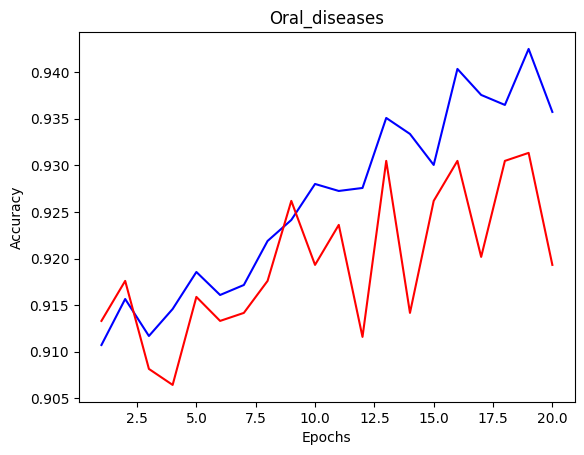

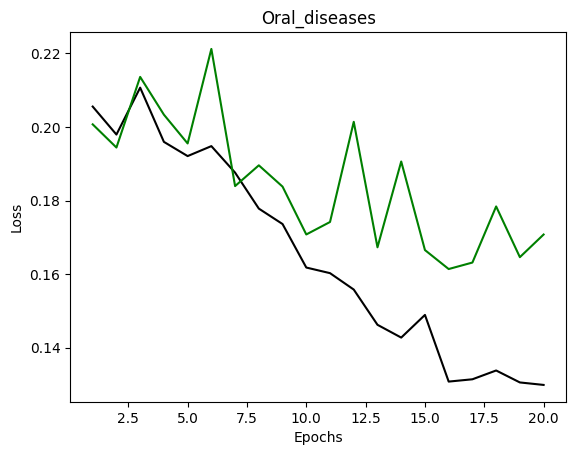

In [13]:
#Visualize models performance
epoch = range(1,len(history.epoch)+1)
results = history.history
plt.plot(epoch,results['accuracy'],'blue')
plt.plot(epoch,results['val_accuracy'],'red')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Oral_diseases')
plt.show()
plt.plot(epoch,results['loss'],'black')
plt.plot(epoch,results['val_loss'],'green')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Oral_diseases')
plt.show()

In [14]:
#Evaluating datas on test set
import tensorflow as tf
alg.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy',tf.keras.metrics.Recall(),
     tf.keras.metrics.Precision()])
alg.evaluate(ready_test)

import numpy as np
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from keras.preprocessing import image

# Assuming 'generator' is your ImageDataGenerator.flow_from_directory object
# and 'model' is your trained TensorFlow model

# Get the true labels
true_labels = ready_test.classes

# Get the predicted labels
predicted_probs = alg.predict(ready_test)
predicted_labels = np.argmax(predicted_probs, axis=1)

# Calculate confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)
print("Confusion Matrix:")
print(cm)

# Calculate recall
recall = recall_score(true_labels, predicted_labels, average='macro')
print("Recall:", recall)

# Calculate precision
precision = precision_score(true_labels, predicted_labels, average='macro')
print("Precision:", precision)



107/107 [==============================] - 10s 84ms/step
Confusion Matrix:
[[ 94   1  34   0   0   1]
 [  2 233   2   1   1   0]
 [ 39   2 191   0   1   2]
 [  0   0   0 255   0   0]
 [  1   2   0   2 179   0]
 [  1   0   2   0   0 123]]
Recall: 0.9099591401933781
Precision: 0.9087828273879958


In [15]:
from sklearn.metrics import classification_report

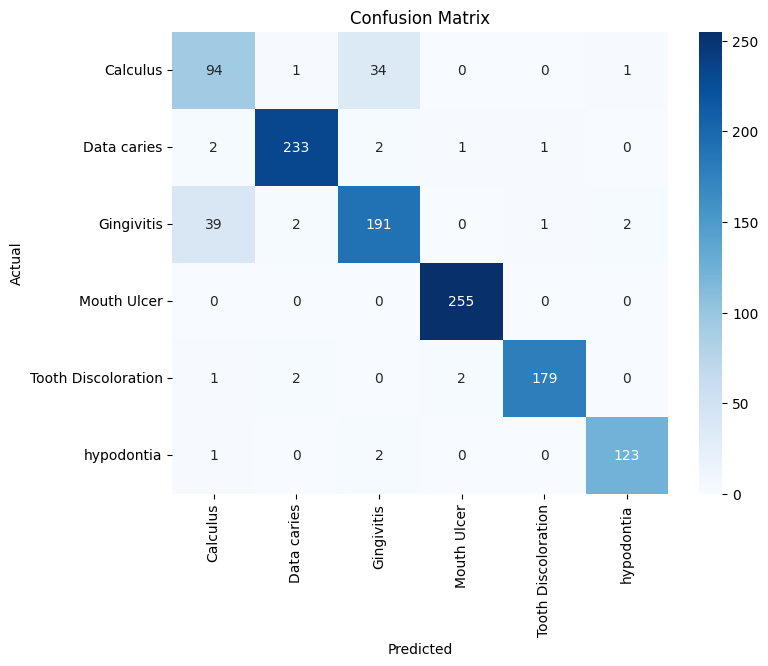

Recall: 0.9099591401933781
Precision: 0.9087828273879958


In [16]:
# Plot the confusion matrix as a heatmap
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from keras.preprocessing import image

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=ready_test.class_indices, yticklabels=ready_test.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

print("Recall:", recall)
print("Precision:", precision)

In [17]:
predictions =alg.predict(ready_test)

107/107 [==============================] - 9s 83ms/step


In [18]:
print(classification_report(predictions.argmax(-1),ready_test.labels))

              precision    recall  f1-score   support

           0       0.69      0.64      0.67       140
           1       0.98      0.95      0.96       246
           2       0.78      0.82      0.80       223
           3       0.99      0.99      0.99       255
           4       0.94      0.97      0.95       179
           5       0.98      0.98      0.98       126

    accuracy                           0.90      1169
   macro avg       0.89      0.89      0.89      1169
weighted avg       0.90      0.90      0.90      1169



In [19]:
predictions.argmax(-1)

array([2, 0, 0, ..., 5, 5, 5])

In [20]:
import cv2

In [21]:
import requests


img_data = requests.get("https://th.bing.com/th/id/R.3c8bb1c5007c51c209a7b7a1bf8a371d?rik=AWpVib0tqWTWCw&pid=ImgRaw&r=0").content
with open('image_name.jpg', 'wb') as handler:
   handler.write(img_data)

In [22]:
ready_test.class_indices

{'Calculus': 0,
 'Data caries': 1,
 'Gingivitis': 2,
 'Mouth Ulcer': 3,
 'Tooth Discoloration': 4,
 'hypodontia': 5}

In [23]:
dic={num:classes for classes ,num in ready_train.class_indices.items()}

In [24]:
img=cv2.imread("/kaggle/input/7wdataset/ready_to_gen/test/Mouth Ulcer/Mouth_Ulcer_0_1014.jpeg")
img=cv2.resize(img,(155,155))
img=img[...,::-1]/255


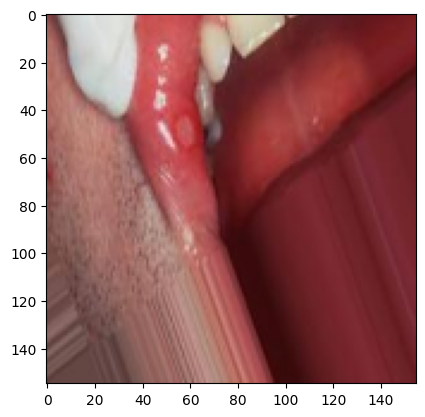

In [25]:
plt.imshow(img)

In [26]:
for i in alg.predict(img[None]):
        print(dic[i.argmax(-1)])

1/1 [==============================] - 1s 1s/step
Mouth Ulcer


In [27]:
for i in alg.predict(img[None]):
   for o in list(reversed(i.argsort( ))):
        print(dic[o])

1/1 [==============================] - 0s 24ms/step
Mouth Ulcer
Tooth Discoloration
Data caries
hypodontia
Calculus
Gingivitis


In [28]:
alg.predict(img[None])

1/1 [==============================] - 0s 24ms/step


array([[5.6798537e-08, 1.1290380e-06, 3.0265465e-08, 9.9999678e-01,
        1.9025871e-06, 1.1596308e-07]], dtype=float32)

In [29]:
! mkdir weights2

In [30]:
alg.save_weights("/kaggle/working/weights2")

In [31]:
! mkdir model2

In [32]:
alg.save("/kaggle/working/model2")

In [33]:
# import pickle
# model_path = 'alg.pkl'

# # Save the model
# with open(model_path, 'wb') as f:
#     pickle.dump(alg, f)

# print(f'Model saved to {model_path}')